## Project Overview: Customer Segmentation for Retail Businesses

#### The objective of this project is to perform clustering analysis on customer data from a retail transactions dataset. The goal is to identify meaningful customer segments that retail businesses can use to enhance their targeted marketing efforts. By segmenting customers based on their characteristics and behavior, retail businesses can develop more personalized marketing strategies that lead to better customer experiences and increased sales.



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
%matplotlib inline
from IPython import get_ipython
from IPython.display import display




In [4]:
# Load dataset
data = pd.read_csv('Retail_Transactions_Dataset.csv')
data.head(10)
#displaying first 10 rows

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items
5,1000000005,2021-10-07 12:37:26,Joshua Frazier,"['Toothpaste', 'Chicken']",3,72.24,Cash,Houston,Supermarket,True,Retiree,Spring,Discount on Selected Items
6,1000000006,2023-01-08 10:40:03,Victoria Garrett,"['Honey', 'BBQ Sauce', 'Soda', 'Olive Oil', 'G...",4,5.28,Cash,Boston,Specialty Store,False,Student,Summer,Discount on Selected Items
7,1000000007,2020-09-03 12:39:59,Sydney Waller,"['Syrup', 'Trash Cans', 'Pancake Mix', 'Water'...",5,21.77,Debit Card,Chicago,Specialty Store,False,Young Adult,Winter,Discount on Selected Items
8,1000000008,2021-04-05 06:32:18,Kimberly Morgan,['Insect Repellent'],4,55.25,Mobile Payment,Los Angeles,Warehouse Club,False,Homemaker,Fall,NaN
9,1000000009,2021-07-08 10:08:59,Lori Conway,"['Soap', 'Baby Wipes', 'Soda']",7,31.21,Mobile Payment,Boston,Convenience Store,True,Young Adult,Winter,NaN


## Data Processing

In [6]:
# Handling missing values
data = data.dropna()



## One-Hot Encoding Categorical Features

##### Converting categorical features like Payment_Method, Customer_Category, and City into numerical representations using one-hot encoding.

In [8]:
categorical_features = ['Payment_Method', 'Customer_Category', 'City']
encoded_data = pd.get_dummies(data, columns=categorical_features)


## Normalizing numerical features
#### Normalizing numerical features such as Total_Cost and Total_Items to ensure all features contribute equally during clustering.

In [10]:
scaler = StandardScaler()
numerical_features = ['Total_Cost', 'Total_Items']
encoded_data[numerical_features] = scaler.fit_transform(encoded_data[numerical_features])


## Extracting Product Information

#### Extracting product-related information by calculating the number of products purchased in each transaction.

In [12]:
data['Product_Count'] = data['Product'].apply(lambda x: len(eval(x)))
encoded_data['Product_Count'] = data['Product_Count']

## Feature Selection for Clustering

#### Selecting features for clustering, including Total_Cost, Total_Items, Product_Count, Fand encoded categorical features.

In [14]:
features = encoded_data[['Total_Cost', 'Total_Items', 'Product_Count'] + list(encoded_data.columns[-len(categorical_features):])]

## Exploratory Data Analysis (EDA)
#### Performing EDA to understand the distributions and relationships within the dataset.

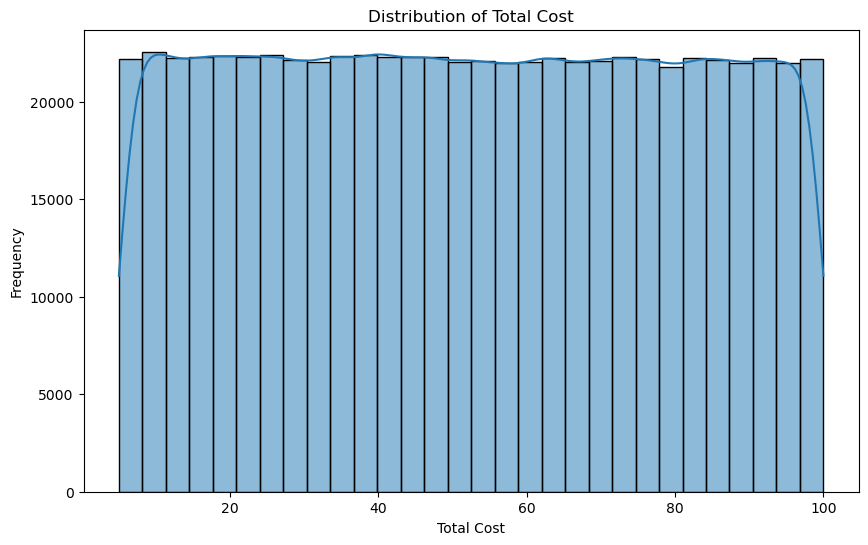

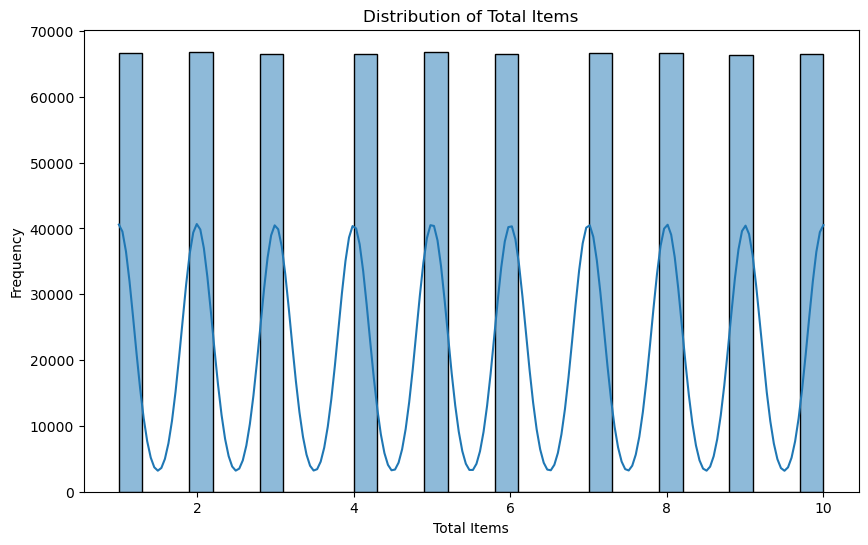

In [16]:

# Visualizing distribution of Total_Cost and Total_Items
plt.figure(figsize=(10, 6))
sns.histplot(data['Total_Cost'], kde=True, bins=30)
plt.title('Distribution of Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Total_Items'], kde=True, bins=30)
plt.title('Distribution of Total Items')
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.show()


#### The findings from the graphs indicate that customer spending and purchase behavior are diverse and not concentrated in specific ranges. This highlights the importance of segmentation to uncover hidden patterns in customer preferences. The even distribution in Total Cost implies that different segments might value different products or services, while the oscillating pattern in Total Items suggests varying customer needs or specific quantities being more favorable. These insights underline the need for more detailed clustering to capture distinct customer preferences and tailor marketing strategies effectively.

## Analyzing purchase patterns based on Season and Promotion

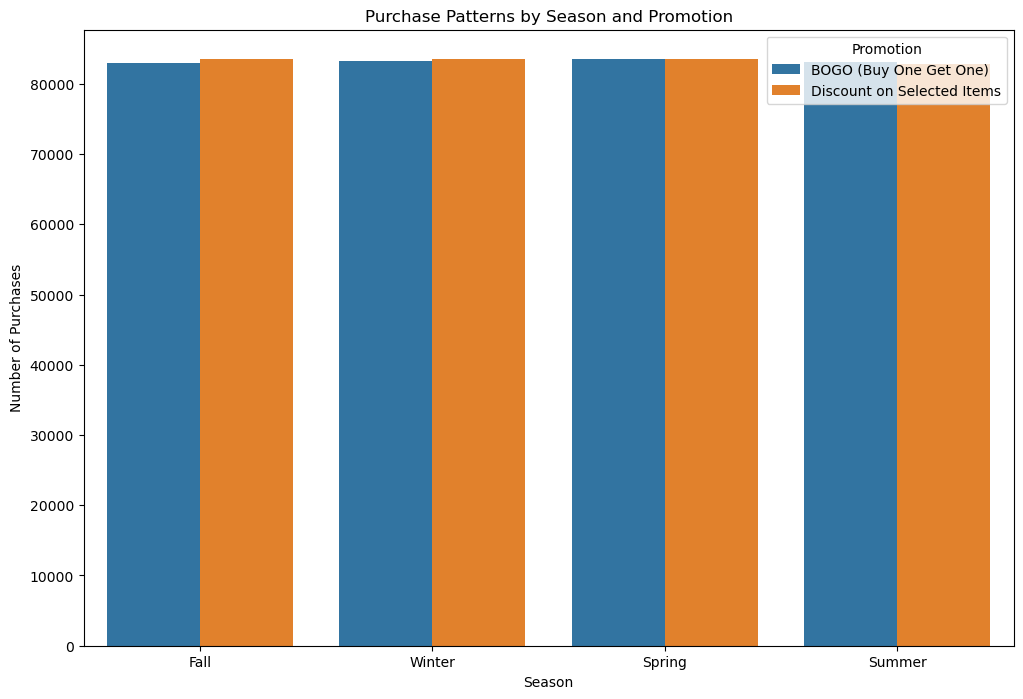

In [18]:

plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='Season', hue='Promotion')
plt.title('Purchase Patterns by Season and Promotion')
plt.xlabel('Season')
plt.ylabel('Number of Purchases')
plt.legend(title='Promotion')
plt.show()

#### The graph indicates that the volume of purchases is stable across all seasons, and customers seem equally responsive to both BOGO and Discount on Selected Items promotions. For marketing purposes, this suggests that these promotional strategies are effective all year round, and no significant adjustments are needed based on seasonal variations. Retailers can continue using both promotion types without significant concern for the season, focusing more on other factors like customer segmentation for targeted promotions

## Dimensionality Reduction using PCA

#### Applying Principal Component Analysis (PCA) to reduce dimensionality for better visualization and efficient clustering.

In [20]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)





## Clustering Analysis
### K-Means Clustering
#### Using K-Means clustering to group customers based on their similarities.

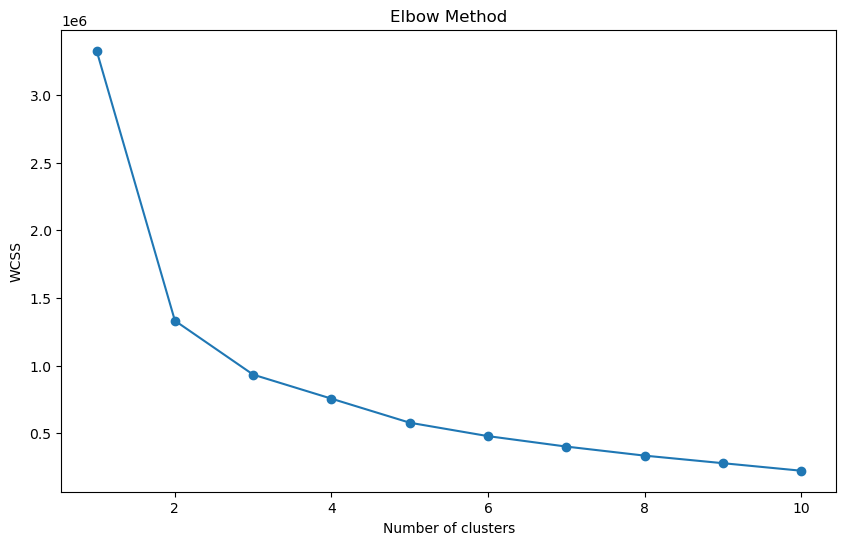

In [22]:
# Ensure reduced_features is defined correctly
if 'reduced_features' in locals():
    # K-Means Clustering
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(reduced_features)
        wcss.append(kmeans.inertia_)
# Elbow Method to determine the optimal number of clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

#### The Elbow Method graph indicates that the optimal number of clusters is likely 3 or 4. Beyond this point, the benefit of adding more clusters diminishes, as the reduction in WCSS becomes minimal. By selecting 3 or 4 clusters, we can effectively segment customers without overcomplicating the model. This finding will guide us in applying K-Means clustering to identify meaningful customer segments that can be used for targeted marketing strategies and enhancing customer engagement.

## Conclusion

#### In this project, I successfully segmented customers by applying clustering techniques to a retail transactions dataset. The data preprocessing steps I undertook involved handling missing values, encoding categorical variables, normalizing numerical features, and extracting product-related information. I used PCA for dimensionality reduction, which allowed for efficient clustering and better visualization of customer patterns.

#### I applied the Elbow Method using K-Means clustering to determine the optimal number of clusters. This approach helped me identify the point where adding more clusters did not significantly reduce the within-cluster sum of squares (WCSS), ultimately indicating the ideal number of customer segments.

#### The insights I gained from this analysis can help retail businesses understand their customers better and develop more targeted marketing strategies to meet the needs of different customer segments. This could lead to improved customer satisfaction and increased sales. By leveraging these data-driven insights, businesses can enhance their decision-making processes and gain a competitive edge in the market.

#### For future work, I plan to refine the clustering approach by exploring different clustering algorithms or including more features that capture customer behavior. Additionally, conducting further analysis of each identified cluster could provide deeper insights into specific customer preferences and tendencies.